In [1]:
%matplotlib inline
from os.path  import join
import Packages.DataLoaders as loader
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import Packages.models as models

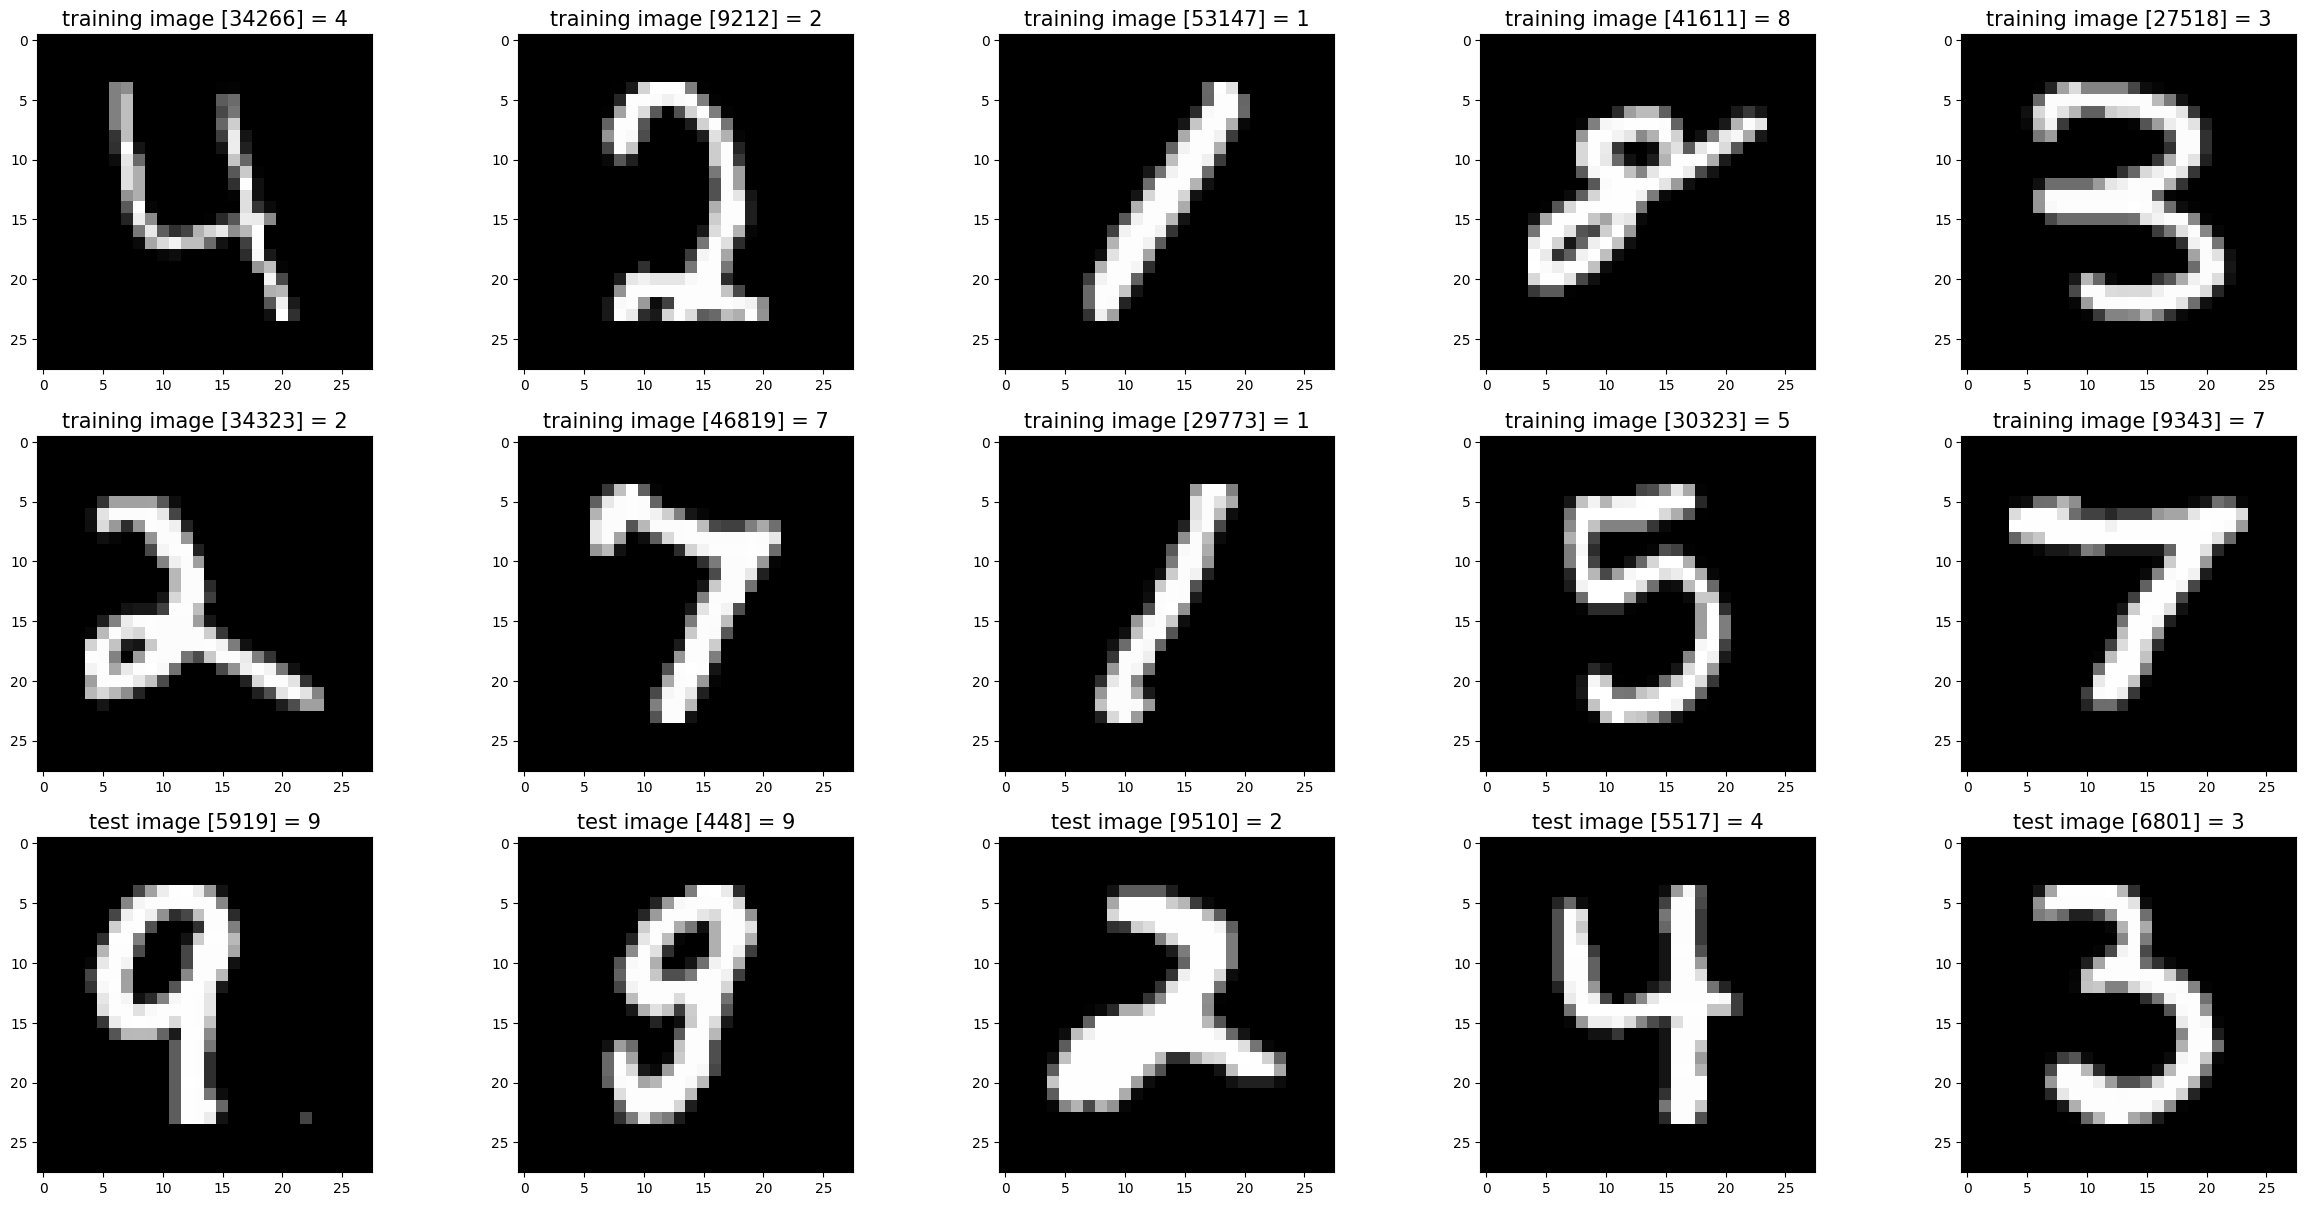

In [2]:

input_path = './Data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = loader.MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data_cropped()
n_train_first = len(x_train)
# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [3]:
font_loader = loader.FontDigitImageLoader(join(input_path,"Digits"),1)

In [4]:
font_images = font_loader.GetImages()
font_labels = font_loader.GetLabels()
x_train.extend(font_images)
y_train.extend(font_labels)

n_train_second = len(x_train)
print(n_train_second)

70160


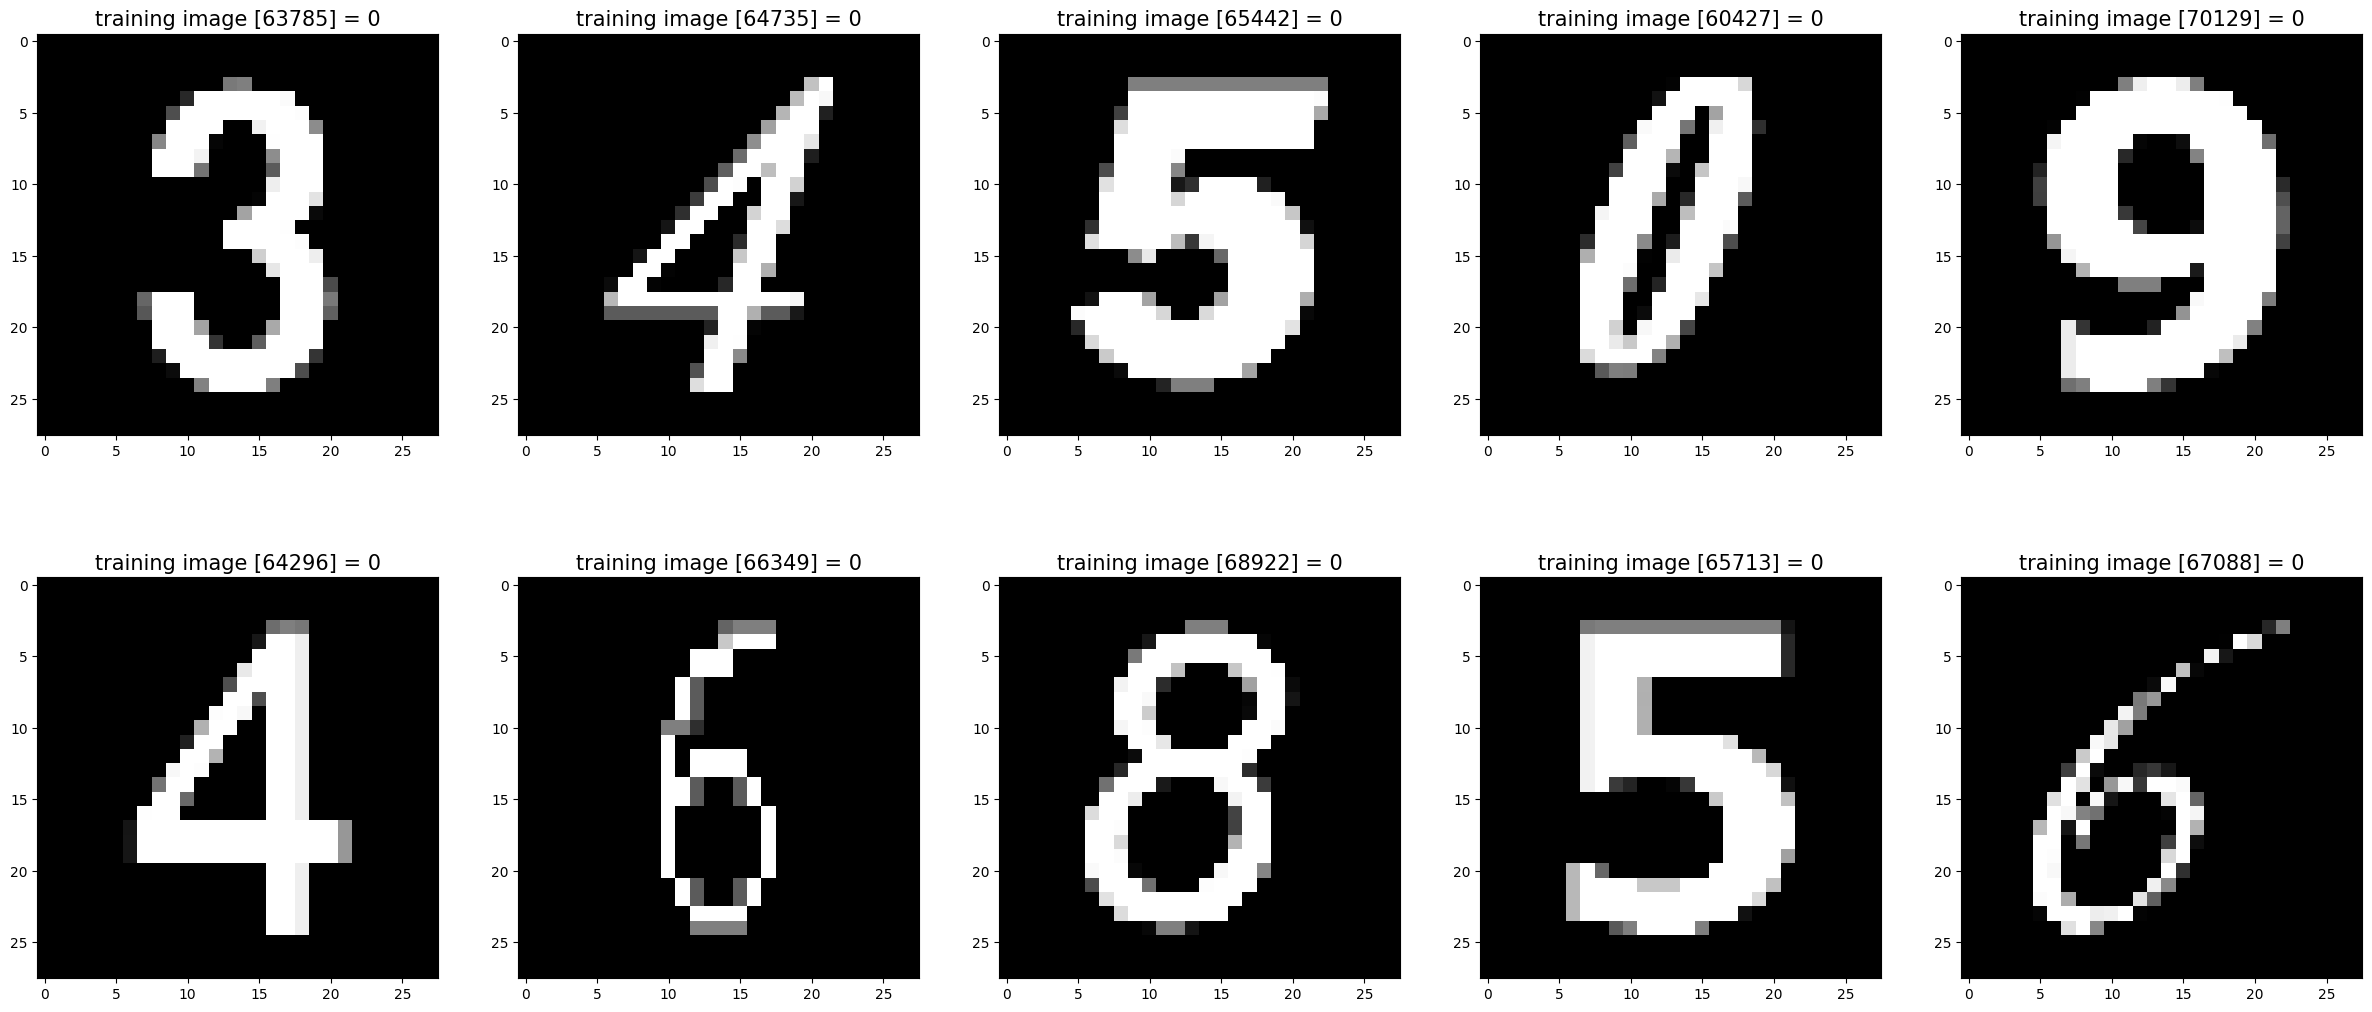

In [5]:
# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(n_train_first, n_train_second-1)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 
show_images(images_2_show, titles_2_show)

In [6]:
# Appending an empty image with 10 as label
x_train.append(np.zeros((28,28)))
y_train.append(10)
x_test.append(np.zeros((28,28)))
y_test.append(10)

# Change the weights so that the empty image becomes more important.
w = np.ones(11)
w[-1]=w[-1]*1000

In [7]:
# Using the sudokus as test data
sudoku_data = []
sudoku_labels = []

# Load the image
processor1 = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku1.png"),number_path=join(input_path, "Sudokus/sudoku1.npy"))
processor1.create_digits(0.1)
(x1,y1) = processor1.to_test_data()
sudoku_data=sudoku_data+x1
sudoku_labels=sudoku_labels+y1
processor2 = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku2.png"),number_path=join(input_path, "Sudokus/sudoku2.npy"))
processor2.create_digits(0.1)
(x2,y2) = processor2.to_test_data()
sudoku_data=sudoku_data+x2
sudoku_labels=sudoku_labels+y2

In [8]:
type(sudoku_labels[0])

numpy.int32

In [9]:
len(sudoku_data)

162

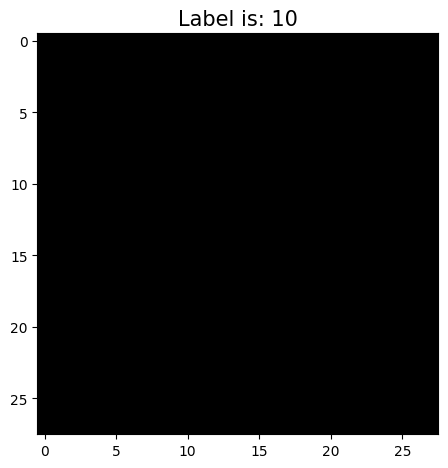

In [10]:
n=104
show_images([np.array(sudoku_data[n])],["Label is: "+str(sudoku_labels[n])])

In [11]:
# Convert NumPy arrays to PyTorch tensors
images_tensor = torch.stack([torch.from_numpy(img).float() for img in x_train])
labels_tensor = torch.from_numpy(np.array(y_train, dtype=int)).long()
test_images_tensor = torch.stack([torch.from_numpy(img).float() for img in x_test])
test_labels_tensor = torch.from_numpy(np.array(y_test, dtype=int)).long()
sudoku_images_tensor = torch.stack([torch.from_numpy(img).float() for img in sudoku_data])
sudoku_labels_tensor = torch.from_numpy(np.array(sudoku_labels, dtype=int)).long()

# Create a custom dataset using TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
sudoku_dataset = TensorDataset(sudoku_images_tensor, sudoku_labels_tensor)

# Create a DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
sudoku_data_loader = DataLoader(sudoku_dataset, batch_size=batch_size, shuffle=True)

In [12]:
def Test(model):
    # Testing the model
    correct = 0
    total = 0
    correct_sudoku = 0
    total_sudoku = 0
    with torch.no_grad():
        for data in test_data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        for data in sudoku_data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_sudoku += labels.size(0)
            correct_sudoku += (predicted == labels).sum().item()
    return (correct / total,correct_sudoku / total_sudoku)
def OneSeedProgram(i,epochs):
    # Set random seed
    torch.manual_seed(i)

    # Initialize the neural network, loss function, and optimizer
    model = models.ConvolutionalNN()
    criterion = nn.CrossEntropyLoss(weight = torch.FloatTensor(w))
    # Define your optimizer with L2 regularization (weight decay)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    best_model = None
    best_score = 0
    for epoch in range(epochs):
        running_loss = 0.0
        for data in data_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(data_loader)}")
        (acc,acc_sud) = Test(model)
        print(f"Epoch {epoch + 1}/{epochs}, Accuracy on the test set: {acc * 100:.2f}%")
        print(f"Epoch {epoch + 1}/{epochs}, Accuracy on the sudoku set: {acc_sud * 100:.2f}%")
        if acc>best_score:
            best_score = acc
            best_model = model
    acc = Test(model)
    print(f"Best accuracy on the test set: {best_score * 100:.2f}%")
    return (acc,model,best_score,best_model)

In [13]:
(end_score,end_model,score,model) = OneSeedProgram(7,30)
torch.save(model.state_dict(), "model")
# model = models.ConvolutionalNN()
# model.load_state_dict(torch.load("model"))
# model.eval()

Epoch 1/30, Loss: 0.29153698581014487
Epoch 1/30, Accuracy on the test set: 97.08%
Epoch 1/30, Accuracy on the sudoku set: 40.12%
Epoch 2/30, Loss: 0.06450207953399353
Epoch 2/30, Accuracy on the test set: 98.13%
Epoch 2/30, Accuracy on the sudoku set: 95.06%
Epoch 3/30, Loss: 0.04695045488201308
Epoch 3/30, Accuracy on the test set: 98.22%
Epoch 3/30, Accuracy on the sudoku set: 88.89%
Epoch 4/30, Loss: 0.04029435064795534
Epoch 4/30, Accuracy on the test set: 98.24%
Epoch 4/30, Accuracy on the sudoku set: 90.12%
Epoch 5/30, Loss: 0.03374859042824749
Epoch 5/30, Accuracy on the test set: 98.15%
Epoch 5/30, Accuracy on the sudoku set: 76.54%
Epoch 6/30, Loss: 0.0300432018865282
Epoch 6/30, Accuracy on the test set: 98.50%
Epoch 6/30, Accuracy on the sudoku set: 91.36%
Epoch 7/30, Loss: 0.026195367510298155
Epoch 7/30, Accuracy on the test set: 98.55%
Epoch 7/30, Accuracy on the sudoku set: 91.98%
Epoch 8/30, Loss: 0.024613514193174504
Epoch 8/30, Accuracy on the test set: 98.43%
Epoch 

In [14]:
print(model.forward(torch.from_numpy(np.zeros((28,28))).float()))

tensor([[-3.6275, -3.1999, -4.0107, -4.4279, -3.9289, -3.1549, -4.0524, -3.5859,
         -3.7138, -3.9680,  6.9742]], grad_fn=<AddmmBackward0>)


In [15]:
"""
# This is for when we want to run over multiple seeds
import Packages.priorityQueue as pq

q = pq.PriorityQueue(3)
for i in range(10):
    print("Seed number: "str(i))
    q.AddElement(OneSeedProgram(i,15))
print(q.getList())
"""

'\n# This is for when we want to run over multiple seeds\nimport Packages.priorityQueue as pq\n\nq = pq.PriorityQueue(3)\nfor i in range(10):\n    print("Seed number: "str(i))\n    q.AddElement(OneSeedProgram(i,15))\nprint(q.getList())\n'

In [16]:
arr = processor.predictions(model)
print(arr)
arr = 

SyntaxError: invalid syntax (1454566741.py, line 3)

In [ ]:
print(processor.get_numbers())